<a href="https://colab.research.google.com/github/thad75/OptionAI/blob/main/TP5/TPSR2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gdown
!gdown 1a7ZViLBLoCHKuLP8CSP_5uj0CTABqDaQ
!mkdir ml-100k
!tar -xf ml-100k.tar.xz -C ml-100k/
!rm -d ml-100k.tar.xz

Downloading...
From: https://drive.google.com/uc?id=1a7ZViLBLoCHKuLP8CSP_5uj0CTABqDaQ
To: /home/nicolas/Documents/OptionAI/TP5/ml-100k.tar.xz
100%|████████████████████████████████████████| 710k/710k [00:00<00:00, 3.32MB/s]
mkdir: cannot create directory ‘ml-100k’: File exists


# TP5 : Graph Neural Networks for Recommendation Systems

In this last TP, you are going to explore the use of Graph Neural Networks (GNNs) for Recommendation Systems.

The dataset you'll use is the dataset **MovieLens 100K**. This dataset describes people's expressed preference for movies. Each preference is described as a tuple (user, movie, rating). 

Users and movies description are also added. On one side, users are defined by their age, sex, occupation and location. On the other side, movies are described by 19 categories, for which each movie can belong to one or more.

This TP is two-fold. First part concerns the computation and the analysis of the dataset, and will mostly be treated in TD, and second part is about the use of GNNs for movie recommendation.

## Part 1 : Dataset analysis

### Libraries to include

First of all, here are some libraries that you may need during this TP. Some of them are not mandatory, while other ones might not be used at all.

In [3]:
import math
import copy
import pickle
import glob
import os
import sys
import time
from pathlib import Path
from itertools import zip_longest
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

### Setting the random seeds
Used in order to fix the randomness of the experiments. It will be probably useless here, but it is always prefered.

In [4]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

RANDOM_STATE = 2021
set_random_seed(RANDOM_STATE)

### Read the dataset files using pandas

You start to work here ! First of all, we need to read the data. For this, we are going to use pandas. We also use this stage to remove the unused fields.

The unused fields are : 
- timestamp in ratings
- movieId, movie title, release data, video release date and IMDb URL for movies
- user id and zip code for users

We also use this stage to ont hot encode and normalize our data. Movies categories are already one hot encoded, so we only need to encode the sex and occupation fields. For normalization, we'll normalize the age field.

In [5]:
def read_data(path):
    files = {}
    path = Path(path)
    for filename in path.glob('*'):
        if filename.suffix == '.data': 
            if filename.stem == 'u':
                columns = ['userId', 'movieId', 'rating', 'timestamp']
                data = pd.read_csv(filename, sep='\t', names=columns, engine='python', encoding='latin-1')
                data.drop(columns = "timestamp", inplace= True)
                files['ratings'] = data
                
        elif filename.suffix == '.item': 
            if filename.stem == 'u':
                # TODO
                columns=['movie id','movie title','release date','video release date','IMDb URL','Action','Adventure','Animation','Children\'s','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
                data = pd.read_csv(filename, sep='|', names=columns, engine='python', encoding='latin-1')   
                data.drop(columns = ['movie id','movie title','release date','video release date','IMDb URL'], inplace= True)
                files['movies'] = data
                
        elif filename.suffix == '.user': 
            if filename.stem == 'u':
                # TODO
                columns = ['userid', 'age','sex','occupation','zip code']
                data = pd.read_csv(filename, sep='|', names=columns, engine='python', encoding='latin-1')
                data.drop(columns = ['userid','zip code'], inplace= True)
                #Normalize age
                #data['age'] = (data['age'] - data['age'].min()) / (data['age'].max() - data['age'].min())
                data['age'] = data['age'] / data['age'].max()

                #One hot encoding of the sex column
                #How to hot encode a gender column
                #https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

                #Hot enconde the sex column
                one_hot = pd.get_dummies(data['sex'],prefix='sex').astype(int)
                data.drop('sex', axis=1, inplace=True)
                data = data.join(one_hot)

                #Hot encode the occupation column
                one_hot = pd.get_dummies(data['occupation'],prefix='occupation').astype(int)
                data.drop('occupation', axis=1, inplace=True)
                data = data.join(one_hot)
                       

                files['users'] = data
                


    return files['ratings'], files['movies'], files["users"]

dataset = 'ml-100k'
ratings, movies, users = read_data(dataset)



We can check what our ratings looks like : 

In [6]:
ratings.head()

,userId,movieId,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


We can do the same for movies and users

In [7]:
movies.head()

,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [8]:
users.head()

,age,sex_F,sex_M,occupation_administrator,occupation_artist,occupation_doctor,occupation_educator,occupation_engineer,occupation_entertainment,occupation_executive,...,occupation_marketing,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer
0,0.328767,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.726027,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.315068,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.328767,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.452055,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### Analysis

Let's take some time to analyze a bit our dataset. We can for example plot the the histogram of ratings. What do you observe ? 

<Axes: >

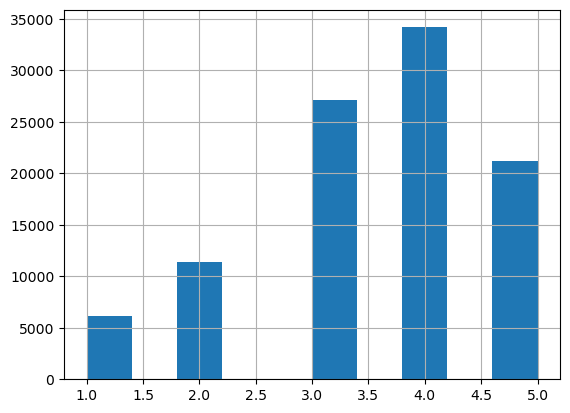

In [9]:
ratings["rating"].hist()

__Plot the different features and analyse them.__

<Axes: >

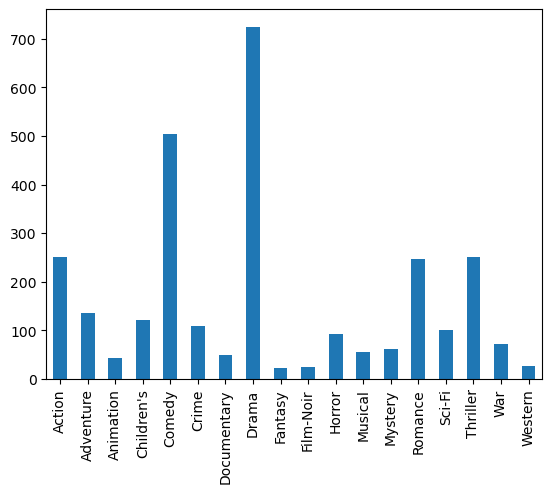

In [10]:
movies.sum().plot.bar()

<Axes: >

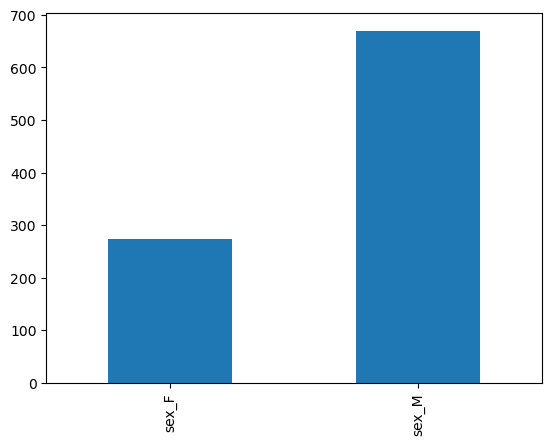

In [11]:
# TODO : plot the histogram for the users sex
#users["M"].hist()
users[["sex_F","sex_M"]].sum().plot.bar()

<Axes: >

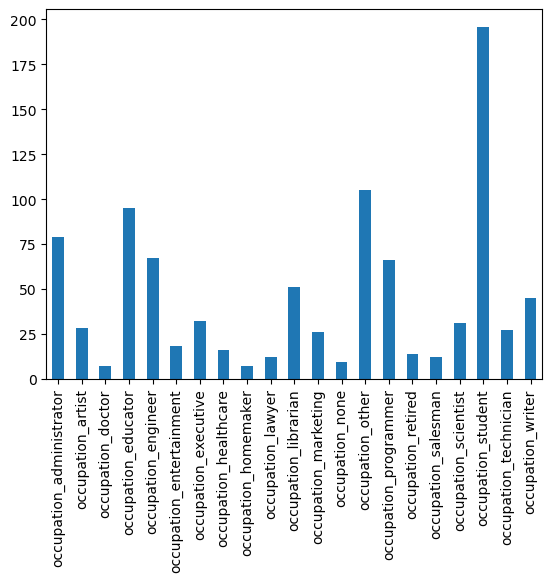

In [12]:
# TODO : plot the histogram for the users occupation

users.columns
occupations = users.columns[3:]

users[occupations].sum().plot.bar()


<Axes: >

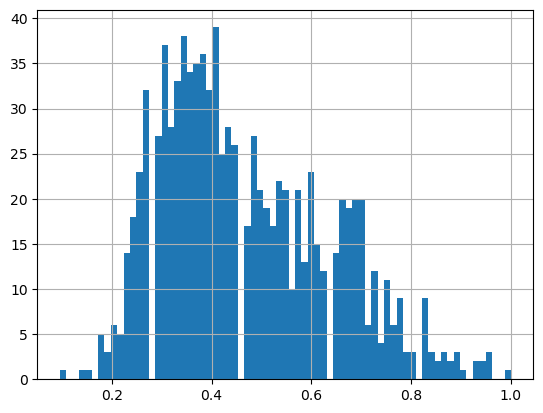

In [13]:
# TODO : plot the histogram for the users age
users["age"].hist(bins=71)

Comment the different results you obtain. 
* What kind of biases can you see ?
* How do you think those biases may perturb your model ? 
* Do you think AI algorithms used also have biases ? 


## Part 2 : Preparing the dataset 

No more analysis, now we want to apply machine learning models to recommend movies according to this dataset.

First step is to prepare the dataset in order to make it usable by our models.

The following function take the triples from ratings and convert it into X and y, where X are the pair user/movie, and y is the rating to predict.

__Question : why did we modify the user index ?__


In [14]:
def create_dataset(ratings, top=None):
    if top is not None:
        ratings.groupby('userId')['rating'].count()

    unique_users = ratings.userId.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.userId.map(user_to_index)

    unique_movies = ratings.movieId.unique()
    movie_to_index = {old: new for new, old in enumerate(unique_movies)}
    new_movies = ratings.movieId.map(movie_to_index)

    n_users = unique_users.shape[0]
    n_movies = unique_movies.shape[0]

    X = pd.DataFrame({'user_id': new_users, 'movie_id': new_movies})
    y = ratings['rating'].astype(np.float32)
    return (n_users, n_movies), (X, y), (user_to_index, movie_to_index)

(n, m), (X, y), _ = create_dataset(ratings)
print(X.head())
print(y.head())
print(f'Embeddings: {n} users, {m} movies')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')

y

   user_id  movie_id
0        0         0
1        1         1
2        2         2
3        3         3
4        4         4
0    3.0
1    3.0
2    1.0
3    2.0
4    1.0
Name: rating, dtype: float32
Embeddings: 943 users, 1682 movies
Dataset shape: (100000, 2)
Target shape: (100000,)


0        3.0
1        3.0
2        1.0
3        2.0
4        1.0
        ... 
99995    3.0
99996    5.0
99997    1.0
99998    2.0
99999    3.0
Name: rating, Length: 100000, dtype: float32

Now, we have to separate our dataset into 3 parts : train, valid and test. By using the train_test_split() function from sklearn.model_selection, put 60% of the data in training, 20% of the data for validation, and 20% in test.

Hint : the function divide the input into 2 splits...

__Due to the number of entries, you might need to reduce the number of data in training and validation later (personnaly, i have 20% in train and 16% in valid).__

In [15]:
# TO DO : split the datasets

#user train test split
#for getting the test, train and validation set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)



datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid), 'test': (X_test, y_test)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid), 'test': len(X_test)}

print(dataset_sizes)

{'train': 60000, 'val': 20000, 'test': 20000}


Now we have our train, valid and test data, we need to compute the nodes of our graph. 

Here, our graph is a bit particular. It is a **bipartite graph**, where each part represent different entities (users and movies). In order to allow our models to differentiate users and movies, we'll add a new feature, which is going to be 0 if the node is a user, and 1 if the node is a movie. 

We end up by concatenating both matrices into a single one, our node matrix (H in the course)

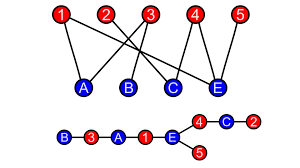

In [16]:

print(f'Users: {users.shape}')
print(f'Movies: {movies.shape}')

def compute_nodes(users, movies):
    # TODO : Create the nodes
    #Create empty dataframe with specified dimension
    df = pd.DataFrame(np.zeros((users.shape[0]+movies.shape[0], max(movies.shape[1],users.shape[1])+1)))
    for i in range(len(users)):
        df.loc[i]=list(users.iloc[i])+[0]
    for i in range(len(movies)+1,len(movies)+len(users)):
        df.loc[i]=list(movies.iloc[i-len(movies)+1])+[0,0,0,0,0,0,1]


    return df



compute_nodes(users, movies)

#print(len(movies),len(movies)+len(users))

Users: (943, 24)
Movies: (1682, 18)


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.328767,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.726027,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.315068,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.328767,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.452055,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2620,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2621,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2622,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2623,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


We also compute the corresponding adjacency matrix.

__Question : why do we only use X_train to compute the adjacency matrix ?__

In [17]:
def compute_adjacency_matrix(X_train):

    #nodes = compute_nodes(X_train).iloc[0]
    num_users = max(X_train['user_id'])+1
    num_movies = max(X_train['movie_id'])+1

    print(num_users,num_movies)

    # TODO : Create the adjacency matrix
    #Create empty numpy matrix
    adj = np.zeros((num_users+num_movies,num_users+num_movies))

    for pais in X_train.values:
         adj[pais[0]][pais[1]+num_users-1] = 1
         adj[pais[1]+num_users-1][pais[0]] = 1
    
    return adj
    
    
adjacency_matrix = compute_adjacency_matrix(X_train)
full_adj = compute_adjacency_matrix(X)

adjacency_matrix

adjacency_matrix.shape

943 1682
943 1682


(2625, 2625)

__By using matplotlib, plot both adjacency_matrix. What do you observe ?__

Once it is done, we won't use full_adj anymore

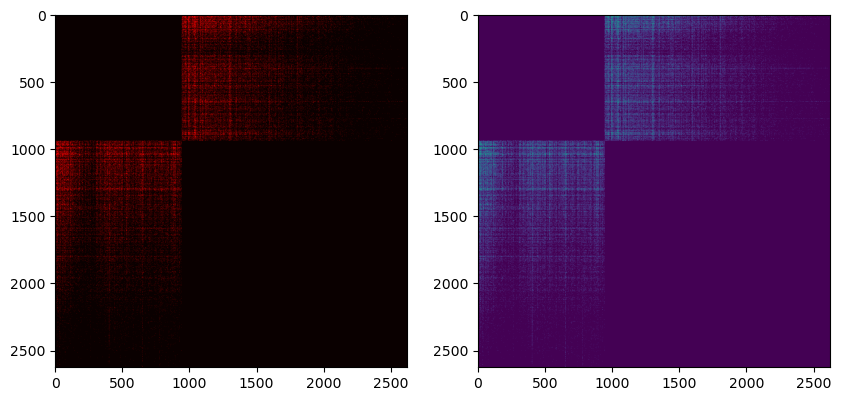

In [18]:
# TODO : plot the adjacency matrix and the full_adj matrix

#Plot both matrices using subplot, also using fisize

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(adjacency_matrix, cmap='hot')
ax2.imshow(full_adj)
    





## Part 3 : Training section

We now have almost everything we need to train our model. First thing is to convert X_train, y_train, X_valid, y_valid, X_test and y_test into tensors (your job)

In [19]:
# TODO : Transform your data into Tensors


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)



X_train = torch.tensor(X_train.to_numpy())
y_train = torch.tensor(y_train.to_numpy())
X_valid = torch.tensor(X_valid.to_numpy())
y_valid = torch.tensor(y_valid.to_numpy())
X_test = torch.tensor(X_test.to_numpy())
y_test = torch.tensor(y_test.to_numpy())






Next step is to define a GNN Layer. Complete the following code in order to compute a simple GNN layer \sigma(AHW+b)

In [20]:
class GNN_layer(nn.Module):
    def __init__(self, input_dim, output_dim=64): 
        super(GNN_layer,self).__init__()
        
        # TODO :
        # Attributes : input dim and output dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # Non linearity : ReLU for example

        self.relu = nn.ReLU()
        #Layer : Linear layer}
        
        self.linear = nn.Linear(input_dim, output_dim)



        
    def forward(self, nodes, adjacency):
        # TODO : 
        # AH multiplication

        out = torch.mm(adjacency, nodes)
    
        
        # Apply Linear layer and non linearity

        out = self.linear(out)
        out = self.relu(out)
        

        return out




We now define our model. This model takes as input the nodes, the adjacency matrix, and the list of pair to predict X_(train/valid/test). It returns a value for each pair to predict. 

Complete the model in order to use one gnn layer you previously computed, and one linear layer to predict for each pair. 

In [21]:
class GNN_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN_model, self).__init__()
        # TO DO
        # Attributes : intput dim, hidden dim (and output dim ?)
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        
        # Add a GNN layer

        self.gnn_layer = GNN_layer(input_dim, hidden_dim)

        
        # Decision layer. Do we need an activation function ? If not, why ? If yes, which one ?

        self.decision_layer = nn.Linear(2*hidden_dim, output_dim)

        
    def forward(self, nodes, adjacency, X):
        # TO DO 
        # Apply GNN layer : 

        nodes = self.gnn_layer(nodes, adjacency)
        
        
        # Concatenate each pair of features for X. Given, because we are generous :)
        node_pair = nodes[X].reshape((X.shape[0], 2*self.hidden_dim))
        # Apply decision layer. Not given because we are not THAT generous 

        out = self.decision_layer(node_pair)
        
        return out

        

Time to train ! 

* Start by transforming the adjacency matrix and the nodes matrix into tensors.
* At each epochs, make one step of training, and one step of validation, and save both losses into lists
* Plot the training curves.

In [22]:
nb_epochs = 1000

loss_train = []
loss_valid = []

nodes = compute_nodes(users, movies).to_numpy()


nodes_tensor = torch.from_numpy(nodes).float().to(device)
adjacency_matrix_tensor = torch.from_numpy(adjacency_matrix).float().to(device)

# TO DO : Define your model, your loss and your optimizer

model = GNN_model(25, 64, 1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


for i in tqdm(range(nb_epochs)):
    # TO DO 
    # As you've done in previous TP, apply your model on your TRAIN data, compute the loss and backpropagate it. 
    # Also add your loss to your list

    optimizer.zero_grad()
    out = model(nodes_tensor, adjacency_matrix_tensor, X_train)

    loss = criterion(out, y_train)
    loss.backward()
    optimizer.step()
    loss_train.append(loss.item())


    # Now, apply your model on your VALID data. Compute your loss but do NOT backpropagate it. It is only for validation !
    # Also add your lost to your list

    out = model(nodes_tensor, adjacency_matrix_tensor, X_valid)
    loss = criterion(out, y_valid)
    loss_valid.append(loss.item())

    
# TO DO : Apply you model on TEST data and compute the Root Mean-Squared Error (outside the loop)

out = model(nodes_tensor, adjacency_matrix_tensor, X_test)
loss = criterion(out, y_test)
print("RMSE : ", loss.sqrt())



# TO DO : plot both loss train and loss valid

plt.plot(loss_train, label='train')
plt.plot(loss_valid, label='valid')
plt.legend()
plt.show()



del model

  0%|          | 0/1000 [00:00<?, ?it/s]/home/nicolas/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([60000])) that is different to the input size (torch.Size([60000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: [enforce fail at alloc_cpu.cpp:75] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 14400000000 bytes. Error code 12 (Cannot allocate memory)

We now want to improve our GNN model into a Vanilla GNN :  $\sigma((A+I)HW)$.

 No need to change our layer, we only need to change our adjacency matrix ! 

In [ ]:
nb_epochs = 1000

loss_train = []
loss_valid = []

nodes_tensor = torch.from_numpy(nodes).float().to(device)
# TO DO : modify your adjacency matrix tensor. The rest should not change from previous question

# TO DO : Define your model, your loss and your optimizer

for i in tqdm(range(nb_epochs)):
    # TO DO 
    # As you've done in previous TP, apply your model on your TRAIN data, compute the loss and backpropagate it. 
    # Also add your loss to your list

    # Now, apply your model on your VALID data. Compute your loss but do NOT backpropagate it. It is only for validation !
    # Also add your lost to your list
    
# TO DO : Apply you model on TEST data and compute the Root Mean-Squared Error (outside the loop)


# TO DO : plot both loss train and loss valid


del model

Finally, we want to implement the General GNN. This time, we have to modify our GNN layer in order to compute 2 linear layers :
*  one for the Adjacency Matrix
*  one for the Identity Matrix.

In [ ]:
class GNN_layer_general(nn.Module):
    def __init__(self, input_dim, output_dim=64): 
        super(GNN_layer_general,self).__init__()
        # TO DO :  change the definition of your GNN Layer for General GNN \sigma(AHW1 + IHW2)
        # Attributes : input dim and output dim

        
        # Non linearity : ReLU for example

        
        # Layer : Linear layers

    def forward(self, nodes, adjacency):
        # TO DO : Compute your general GNN

        return out_1+out_2 # <= this is an hint, but you can modify it if this helps you *WINK WINK*

In [ ]:
class GNN_model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNN_model, self).__init__()
        # TO DO : redefine your GNN model. SHould not change from before, but you need to reexecute it
        
        # Attributes : intput dim, hidden dim (and output dim ?)

        # Add a GNN layer

        
        # Out layer. Do we need an activation function ? 
        
        
    def forward(self, nodes, adjacency, X):
        # TO DO :
        # Apply GNN layer : 
        
        
        # Concatenate each pair of features for X. Given, because we are generous :)
        node_pair = nodes[X].reshape((X.shape[0], 2*self.hidden_dim))
        # Apply decision layer. Not given because we are not THAT generous 
        
        return out


In [ ]:
nb_epochs = 1000

loss_train = []
loss_valid = []

nodes_tensor = torch.from_numpy(nodes).float().to(device)
# TO DO : modify your adjacency matrix tensor. The rest should not change from previous question

# TO DO : Define your model, your loss and your optimizer

for i in tqdm(range(nb_epochs)):
    # TO DO 
    # As you've done in previous TP, apply your model on your TRAIN data, compute the loss and backpropagate it. 
    # Also add your loss to your list

    # Now, apply your model on your VALID data. Compute your loss but do NOT backpropagate it. It is only for validation !
    # Also add your lost to your list
    
# TO DO : Apply you model on TEST data and compute the Root Mean-Squared Error (outside the loop)


# TO DO : plot both loss train and loss valid


del model

__Some Meme for The end__
<div align ='center'><img src="https://i.imgflip.com/7irtot.jpg" height='200' title="made at imgflip.com"/>

<img src="https://i.imgflip.com/7irtuv.jpg" height='200'  title="made at imgflip.com"/>

<img src="https://i.imgflip.com/7iru6r.jpg" height='200' title="made at imgflip.com"/>
<img src="https://i.imgflip.com/7iru46.jpg" height='200' title="made at imgflip.com"/>


</div>